In [121]:
import sys
sys.path.append('../')
import torchio as tio
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.autograd import Variable
import torch.cuda as cuda
import torch.nn as nn
import torch
from torch.distributions import Normal
from mlp.datasets import QSM_slices
import os
import numpy as np
import util
import sklearn.preprocessing as skp
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [122]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528_wldd.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','pre op levadopa equivalent dose (mg)','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off,ledd = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo',
                                                          'pre op levadopa equivalent dose (mg)')
print(ledd)
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,False)
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,0:4,:]
K_all_c = K_all[c_cases_idx,0:4,:]
R_all_c = R_all[c_cases_idx,0:4,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subs_init = subs[s_cases_idx]
pre_imp_init = pre_imp[s_cases_idx]
post_imp_init = post_imp[s_cases_idx]
pre_updrs_off_init = pre_updrs_off[s_cases_idx]
ledd_init = ledd[s_cases_idx]
per_change_init = post_imp_init
subs = np.asarray(ID_all,dtype=float)[np.in1d(np.asarray(ID_all,dtype=float),subs_init)]
subs0 = subs_init
pre_imp = np.zeros((1,len(subs))).T
post_imp = np.zeros((1,len(subs))).T
pre_updrs_off = np.zeros((1,len(subs))).T
ledd = np.zeros((1,len(subs))).T
per_change = np.zeros((1,len(subs))).T
for j in np.arange(len(subs)):
    pre_imp[j] = pre_imp_init[subs_init == subs[j]]
    post_imp[j] = post_imp_init[subs_init == subs[j]]
    pre_updrs_off[j] = pre_updrs_off_init[subs_init == subs[j]]
    ledd[j] = ledd_init[subs_init == subs[j]]
    per_change[j] = per_change_init[subs_init == subs[j]]

subsc = subs
X_all_c = X_all_c.reshape(X_all_c.shape[0],-1)
X_all_c = np.append(X_all_c,pre_updrs_off,axis=1)
X_all_c = np.append(X_all_c,ledd,axis=1)
print(np.unique(R_all_c))

       Unnamed: 0                PRE-OP           Unnamed: 2  \
0      CORNELL ID  Apathy Off (pre-dbs)  Apathy ON (pre-dbs)   
1              67                    na                   13   
2   only Ct data                     na                   na   
3              74                    na                   na   
4              84                    na                   22   
..            ...                   ...                  ...   
87             52                   NaN                  NaN   
88             53                   NaN                  NaN   
89             54                   NaN                  NaN   
90             55                   NaN                  NaN   
91             56                   NaN                  NaN   

             Unnamed: 3          Unnamed: 4    Unnamed: 5  \
0   OFF (pre-dbs updrs)  ON (pre-dbs updrs)  mri (pre-op)   
1                    60                  41      3/9/2020   
2                    43                  12     

In [176]:
data_dir = os.listdir('../mlp/tensor_slices_10')
scaler = skp.StandardScaler()
X = scaler.fit_transform(X_all_c)
train_dataset = QSM_slices(data_dir=data_dir,aug_state=1, factor=0, X=X,subsc=subsc,targets=per_change,prefix='../mlp/')
data_loader = DataLoader(train_dataset, batch_size=X.shape[0], shuffle=True)
img_size = 64 # Image size
batch_size = 45  # Batch size

# Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_size = 512
generator_layer_size = [512, 1024, 2048]
discriminator_layer_size = [2048, 1024, 512]
N = len(np.unique(np.round(per_change,1)))
# Training
epochs = 1000
learning_rate = 1e-6

In [177]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        x = z
  
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

In [178]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size):
        super().__init__()
        
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [179]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size).to(device)
# Loss function
criterion = nn.BCELoss()

In [200]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [201]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Generating fake images
    fake_images = generator(z)
    
    # Disciminating fake images
    validity = discriminator(fake_images)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [202]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Generating fake images
    fake_images = generator(z)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 0.6070480942726135, d_loss: 1.8011897802352905
Starting epoch 2...
g_loss: 0.6111476421356201, d_loss: 1.8257195949554443
Starting epoch 3...
g_loss: 0.6101539731025696, d_loss: 1.811335802078247
Starting epoch 4...
g_loss: 0.6162188649177551, d_loss: 1.7978556156158447
Starting epoch 5...
g_loss: 0.6061370968818665, d_loss: 1.7917753458023071
Starting epoch 6...
g_loss: 0.6136173009872437, d_loss: 1.776688814163208
Starting epoch 7...
g_loss: 0.6155537366867065, d_loss: 1.7838263511657715
Starting epoch 8...
g_loss: 0.6186681389808655, d_loss: 1.7935982942581177
Starting epoch 9...
g_loss: 0.6275193095207214, d_loss: 1.7806882858276367
Starting epoch 10...
g_loss: 0.6229836344718933, d_loss: 1.7918510437011719
Starting epoch 11...
g_loss: 0.6279265880584717, d_loss: 1.7718778848648071
Starting epoch 12...
g_loss: 0.6236239075660706, d_loss: 1.766202449798584
Starting epoch 13...
g_loss: 0.6236051321029663, d_loss: 1.773136854171753
Starting epoch 14...
g_lo

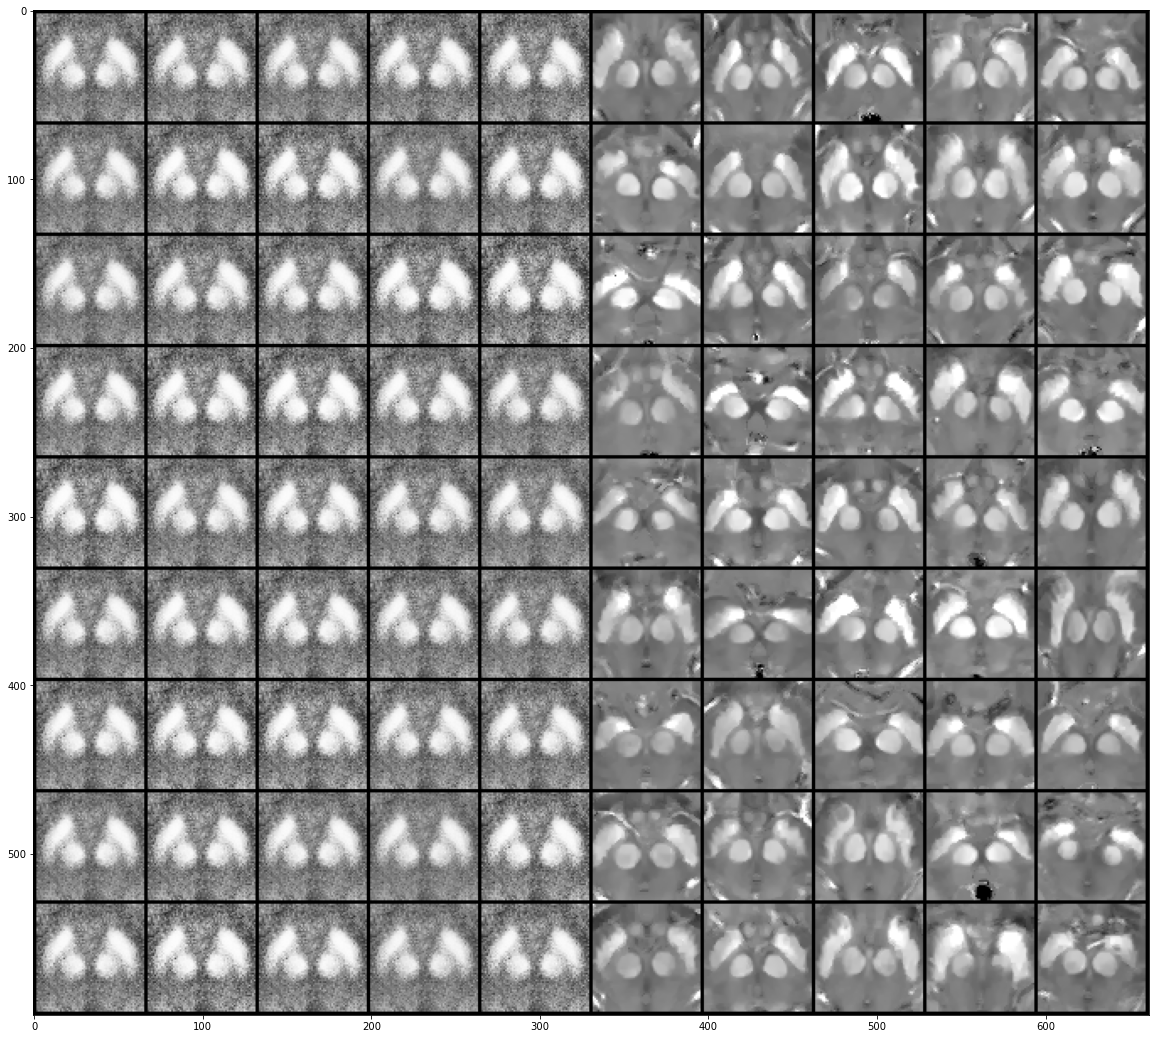

In [203]:

for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, X, labels) in enumerate(data_loader):
        
        # Train data
        real_images = (Variable(images).to(device)/torch.amax(images))#+torch.randn(images.shape).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(len(data_loader.dataset), z_size)).to(device)

    # Generating images
    sample_images = generator(z).unsqueeze(1).data.cpu()

# Show images
print('Generated images range from',torch.min(sample_images),'to',torch.max(sample_images),'and real images range from',torch.min(real_images),'to',torch.max(real_images))
fig, ax = plt.subplots(figsize=(20, 20))
grid = make_grid(torch.vstack((sample_images_out,real_images.cpu())), nrow=9, normalize=True).permute(1,2,0).numpy()
ax.imshow(np.rot90(grid))
fig.show()
print(np.var(z.detach().cpu().numpy(),axis=1))
